# TP1 - Fatima Jordan, Malena Do Brito, Alejo Goncalves - Turno Noche

In [1]:
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import datetime as dt
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from matplotlib.ticker import FuncFormatter
from formulaic import model_matrix, Formula
import numpy as np

## Procesamiento de datos

In [2]:
ruta_datasets = 'data/'

In [3]:
dataset_sube20 = pd.read_csv(ruta_datasets+'dat-ab-usos-2020.csv')
dataset_sube21 = pd.read_csv(ruta_datasets+'dat-ab-usos-2021.csv')
dataset_sube22 = pd.read_csv(ruta_datasets+'dat-ab-usos-2022.csv')
dataset_sube = pd.read_csv(ruta_datasets+'sube-2023.csv')
dataset_sube_regresion = pd.read_csv(ruta_datasets+'sube-2023-regresion.csv')
poblacion_provincias = pd.read_excel(ruta_datasets+'poblacion_provincias.xlsx')
superficie_provincias = pd.read_excel(ruta_datasets+'superficie_provincias.xlsx')

In [4]:
df_concatenado = pd.concat([dataset_sube20,dataset_sube21,dataset_sube22,dataset_sube])

### Ejercicio 1

#### a)

Describimos el dataset

In [5]:
dataset_sube.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472291 entries, 0 to 472290
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   DIA_TRANSPORTE   472291 non-null  object
 1   NOMBRE_EMPRESA   472291 non-null  object
 2   LINEA            472291 non-null  object
 3   AMBA             472291 non-null  object
 4   TIPO_TRANSPORTE  472291 non-null  object
 5   JURISDICCION     469742 non-null  object
 6   PROVINCIA        469720 non-null  object
 7   MUNICIPIO        469720 non-null  object
 8   CANTIDAD         472291 non-null  int64 
 9   DATO_PRELIMINAR  472291 non-null  object
dtypes: int64(1), object(9)
memory usage: 36.0+ MB


Transformamos la columna dia_transporte a datetime

In [6]:
dataset_sube['DIA_TRANSPORTE'] = pd.to_datetime(dataset_sube['DIA_TRANSPORTE'], format='%Y-%m-%d')

#### b)

##### i.

Creamos la columna fecha_dia con el nombre del día de la semana

In [7]:
dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
def obtener_nombre_dia(fecha_dia):
    return dias[fecha_dia.weekday()]

In [8]:
dataset_sube['FECHA_DIA'] = dataset_sube['DIA_TRANSPORTE'].apply(obtener_nombre_dia)

##### ii.

Creamos la columna fecha_ordinal donde asignamos el numero de día del año a cada fecha

In [9]:
dataset_sube['FECHA_ORDINAL'] = dataset_sube['DIA_TRANSPORTE'].dt.day_of_year

##### iii.

Creamos la columna fecha_mes con el numero de mes para cada fecha

In [10]:
dataset_sube['FECHA_MES'] = dataset_sube['DIA_TRANSPORTE'].dt.month

### Ejercicio 2

Creamos un dataframe que contiene solo los datos del AMBA y elimina los datos preliminares

In [11]:
datos_amba = dataset_sube[dataset_sube['AMBA']=='SI']
datos_amba = datos_amba[datos_amba['DATO_PRELIMINAR']=='NO']

Acomodamos el orden de las columnas y les corregimos el formato del nombre

In [12]:
datos_amba = datos_amba[['DIA_TRANSPORTE', 'FECHA_DIA', 'FECHA_MES','FECHA_ORDINAL', 'JURISDICCION', 'LINEA','CANTIDAD', 'TIPO_TRANSPORTE']]

In [13]:
datos_amba = datos_amba.rename(columns={"DIA_TRANSPORTE": "fecha", "FECHA_DIA": "fecha_dia","FECHA_MES" : "fecha_mes", "FECHA_ORDINAL":"fecha_ordinal","JURISDICCION": "jurisdiccion", "LINEA":'linea',"CANTIDAD":"pasajeros", "TIPO_TRANSPORTE": "tipo_transporte"})

Resultado final:

In [14]:
datos_amba.head()

,fecha,fecha_dia,fecha_mes,fecha_ordinal,jurisdiccion,linea,pasajeros,tipo_transporte
0,2023-01-01,Domingo,1,1,MUNICIPAL,1,61,COLECTIVO
1,2023-01-01,Domingo,1,1,MUNICIPAL,2B,11,COLECTIVO
3,2023-01-01,Domingo,1,1,PROVINCIAL,BS_AS_LINEA_326,438,COLECTIVO
5,2023-01-01,Domingo,1,1,MUNICIPAL,BS_AS_LINEA_514,3067,COLECTIVO
6,2023-01-01,Domingo,1,1,MUNICIPAL,BS_AS_LINEA_522,332,COLECTIVO


### Ejercicio 3

#### a)

Calculamos la proporcion de pasajeros por transporte en 2023

In [15]:
pasajeros_totales = sum(datos_amba['pasajeros'])

In [16]:
pasajeros_por_transporte = datos_amba.groupby('tipo_transporte')['pasajeros'].sum()

In [17]:
proporcion_pasajeros = ((pasajeros_por_transporte/pasajeros_totales)*100).round(1)
proporcion_pasajeros = proporcion_pasajeros.map(lambda x: f"{x}%")
proporcion_pasajeros

tipo_transporte
COLECTIVO    83.8%
SUBTE         6.8%
TREN          9.4%
Name: pasajeros, dtype: object

#### b)

Creamos un dataset con los datos del Subte, agrupamos por mes y linea, y obtenemos el valor maximo

In [18]:
datos_subte = datos_amba[datos_amba['tipo_transporte'] == 'SUBTE']
datos_subte = datos_subte[['fecha_mes','linea','pasajeros']]

In [19]:
datos_subte_mesLinea = datos_subte.groupby(['fecha_mes','linea'])['pasajeros'].sum()

In [20]:
mes_linea_maxPasajeros = pd.DataFrame(datos_subte_mesLinea).idxmax()

Tupla (mes, línea de subte) donde viajó la mayor cantidad de pasajeros

In [21]:
mes_linea_maxPasajeros.iloc[0]

(8, 'LINEA_B')

#### c)

Creamos el dataset solo con los días habiles, calculamos el desvío estandar para cada día y vemos el menor

In [22]:
dias_habiles = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes']
datos_amba_habiles = datos_amba[datos_amba['fecha_dia'].isin(dias_habiles)]

In [23]:
desvios = []
for dia_habil in dias_habiles:
    desvio_estandar = datos_amba_habiles[datos_amba_habiles['fecha_dia']==dia_habil]['pasajeros'].std().round(1)
    desvio_dia = (dia_habil, desvio_estandar)
    desvios.append(desvio_dia)
print(desvios)

[('Lunes', 33577.5), ('Martes', 35833.7), ('Miércoles', 35980.8), ('Jueves', 35968.3), ('Viernes', 35059.7)]


In [24]:
dia_menos_desvio = min(desvios, key=lambda x: x[1])
dia_menos_desvio[0]

'Lunes'

## Analisis exploratorio

### Ejercicio 4

Empezamos analizando los aspectos principales de nuestro dataset con los gráficos 1 y 2. Vemos que la cantidad de pasajeros en el transporte público decrece en los meses de vacaciones, ya sea verano o invierno. 

Haciendo un doble-click dentro del tipo de transporte notamos que el colectivo es el mas pujante, siendo el que mas kilometros cuadrados cubre, y el único disponible en todo el país.

##### Grafico 1

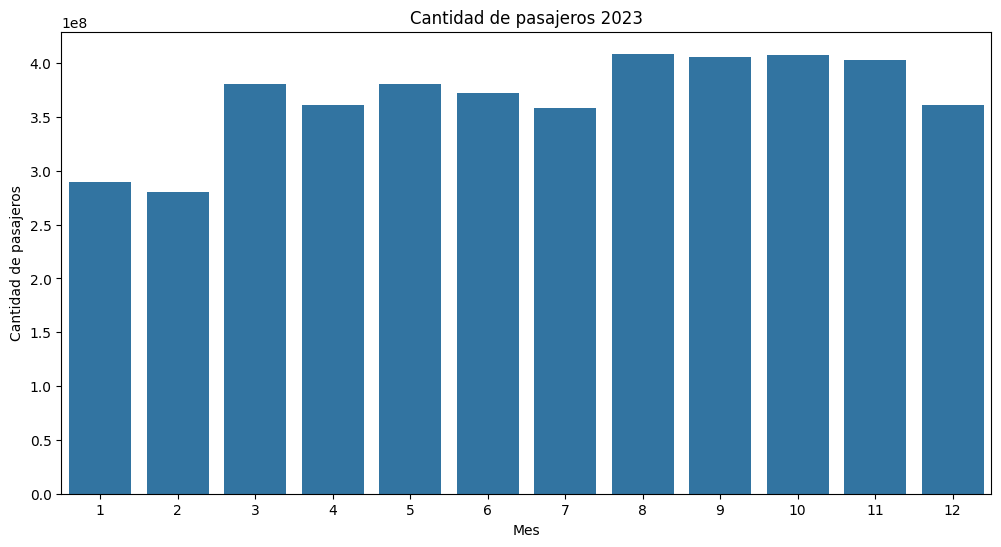

In [25]:
plt.figure(figsize=(12, 6))
sns.barplot(data=dataset_sube, x='FECHA_MES', y='CANTIDAD', errorbar=None,estimator='sum')
plt.title('Cantidad de pasajeros 2023')
plt.xlabel('Mes')
plt.ylabel('Cantidad de pasajeros')
plt.show()

##### Gráfico 2

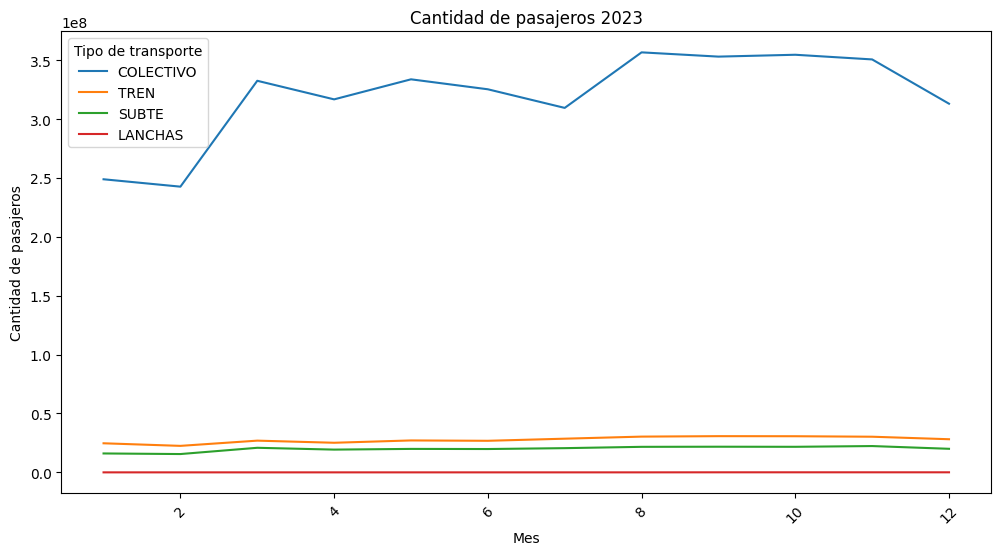

In [26]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=dataset_sube, x='FECHA_MES', y='CANTIDAD', hue='TIPO_TRANSPORTE', errorbar=None,estimator='sum')
plt.title('Cantidad de pasajeros 2023')
plt.xlabel('Mes')
plt.ylabel('Cantidad de pasajeros')
plt.legend(title='Tipo de transporte')
plt.xticks(rotation=45)
plt.show()

##### Gráfico 3

Siguiendo con esta idea, analizamos particularmente los datos de pasajeros en colectivo.

<Figure size 1200x600 with 0 Axes>

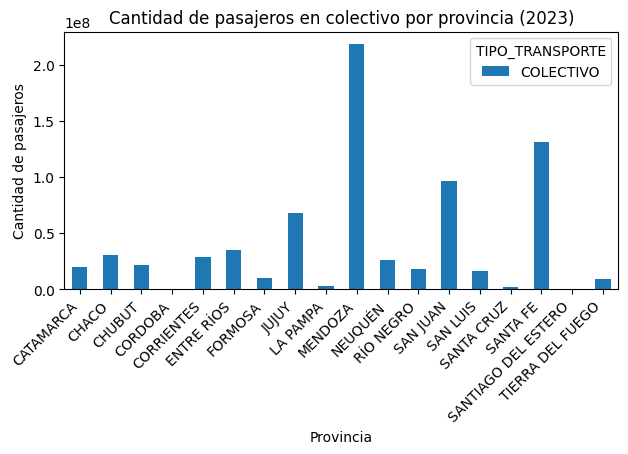

In [27]:
plt.figure(figsize=(12, 6))
datosSinBAJN = dataset_sube[(dataset_sube["PROVINCIA"] != "JN") & (dataset_sube["PROVINCIA"] != "BUENOS AIRES")]
datos_agrupados = datosSinBAJN.groupby(['PROVINCIA', 'TIPO_TRANSPORTE'])['CANTIDAD'].sum().unstack()

datos_agrupados.plot(kind='bar', stacked=True)
plt.title('Cantidad de pasajeros en colectivo por provincia (2023)')
plt.xlabel('Provincia')
plt.ylabel('Cantidad de pasajeros')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

En este gráfico podemos observar la cantidad total de pasajeros que viajaron en colectivo en las provincias de Argentina en 2023, excluyendo a Buenos Aires y JN ya que estos mostraban mucha diferencia en la cantidad de pasajeros y decidimos graficarlos aparte para así poder observar una distribución más equilibrada entre las demás provincias. En conclusión, podemos observar diferencias notables en el uso del colectivo en las diferentes provincias. Las provincias con mayor cantidad de pasajeros en colectivo probablemente cuentan con una mejor infraestructura y accesibilidad en términos de rutas y disponibilidad de transporte público. Podemos notar que en Córdoba no hay ningun registro de uso de la sube en 2023, luego de hacer una busqueda logramos descubrir que en esta provincia se implementó la SUBE a principios del 2024, por lo tanto no hay datos al respecto. Podemos destacar Mendoza, la cual posee mayor uso de la SUBE en comparación a las demas provincias, esto puede deberse a varios factores como la cantidad de poblacion que vive en la provincia, una infraestructura de transporte público más desarrollada, mayor apoyo gubernamental y subsidios.

##### Gráfico 4

C:\Users\gonca025\AppData\Local\Temp\1\ipykernel_36632\281096246.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  datosSoloBAJN = datosSoloBAJN[(datosSoloBAJN["PROVINCIA"] == "JN") | (dataset_sube["PROVINCIA"] == "BUENOS AIRES")]


<Figure size 1200x600 with 0 Axes>

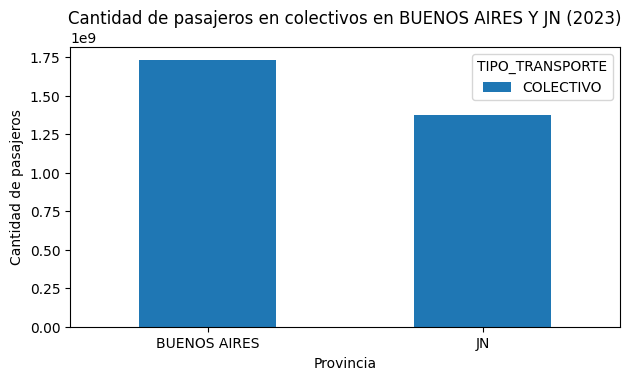

In [28]:
plt.figure(figsize=(12, 6))
datosSoloBAJN = dataset_sube[dataset_sube["TIPO_TRANSPORTE"]=="COLECTIVO"]
datosSoloBAJN = datosSoloBAJN[(datosSoloBAJN["PROVINCIA"] == "JN") | (dataset_sube["PROVINCIA"] == "BUENOS AIRES")]
datos_agrupados2 = datosSoloBAJN.groupby(['PROVINCIA', 'TIPO_TRANSPORTE'])['CANTIDAD'].sum().unstack()

datos_agrupados2.plot(kind='bar', stacked=True)
plt.title('Cantidad de pasajeros en colectivos en BUENOS AIRES Y JN (2023)')
plt.xlabel('Provincia')
plt.ylabel('Cantidad de pasajeros')
plt.tight_layout()
plt.xticks(rotation=0)
plt.show()

El gráfico de barras muestra la cantidad total de pasajeros que viajaron en colectivos en la provincia de Buenos Aires y en Jurisdicción Nacional durante el año 2023. Para este analizis hay que tener en cuenta que Buenos Aires es la capital de Argentina y uno de los centros más importantes del país, donde vive una gran parte de la población y donde se realizan gran parte de las actividades económicas, esto se refleja en la alta demanda de transporte público. La Jurisdicción Nacional, incluye áreas bajo jurisdicción directa del gobierno federal, puede presentar características específicas en cuanto a la distribución de la población, el tipo de actividades y la disponibilidad de transporte público. Estas caracteristicas hacen posiblemente que sea menor la cantidad de pasajeros en colectivos en comparación con Buenos Aires. Además queremos agregar que observamos que la linea BS_AS_LINEA_514 no tiene asignada ninguna provincia (nan), luego de hacer una investigacion, en el dataset exportado desde la página correspondiente vemos que esta linea tiene asignada la provincia de "BUENOS AIRES", igualmente teniendo en cuenta esta diferencia en los datos, podemos afirmar que esto no cambia nuestras conclusiones anteriores ya que se sumarian más datos a la provincia de Buenos Aires que es la que tiene mayor cantidad de información.

##### Gráfico 5

In [29]:
agrupado_provincia = dataset_sube.groupby(['PROVINCIA'])['CANTIDAD'].sum().reset_index()

In [30]:
agrupado_provincia = agrupado_provincia.merge(poblacion_provincias,how='left', on='PROVINCIA')

In [31]:
agrupado_provincia_interior = agrupado_provincia[(agrupado_provincia['PROVINCIA']!='BUENOS AIRES') & (agrupado_provincia['PROVINCIA']!='JN')]

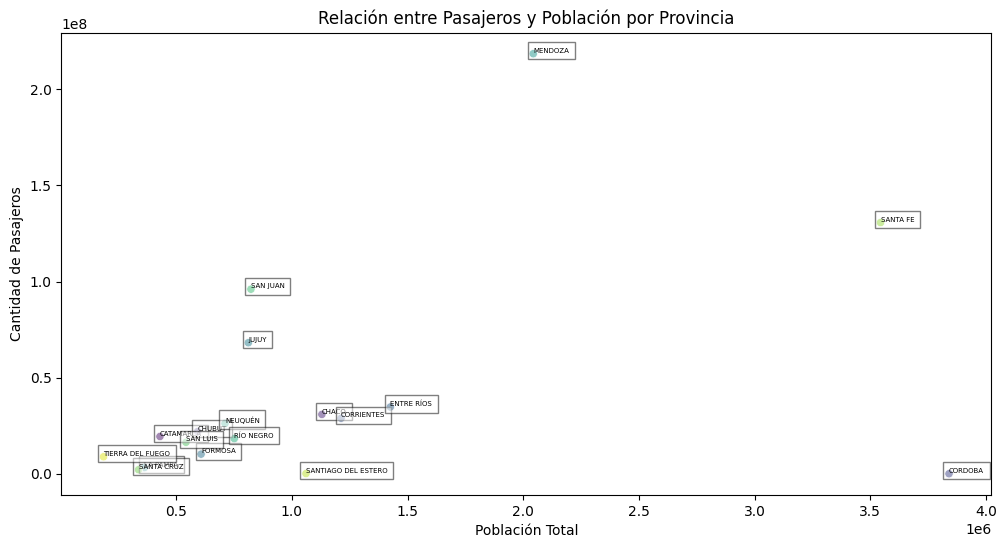

In [32]:
plt.figure(figsize=(12, 6))
scatter = sns.scatterplot(data=agrupado_provincia_interior, x='POBLACION', y='CANTIDAD', hue='PROVINCIA', palette='viridis', legend=False)
for index, row in agrupado_provincia_interior.iterrows():
    scatter.text(row['POBLACION'], row['CANTIDAD'], row['PROVINCIA'], ha='left', fontsize=5, 
                 va='bottom', rotation_mode='anchor', 
                 bbox=dict(facecolor='white', alpha=0.5))
plt.xlabel('Población Total')
plt.ylabel('Cantidad de Pasajeros')
plt.title('Relación entre Pasajeros y Población por Provincia')
# plt.legend(title='Provincia', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Aqui seguimos analizando la distribución de los pasajeros en las provincias (sin BSAS y JN), en relación a la población total de cada provincia. Esto nos muestra que no necesariamente más población implica mas pasajeros, o al menos no es una relación lineal.

##### Gráfico 5

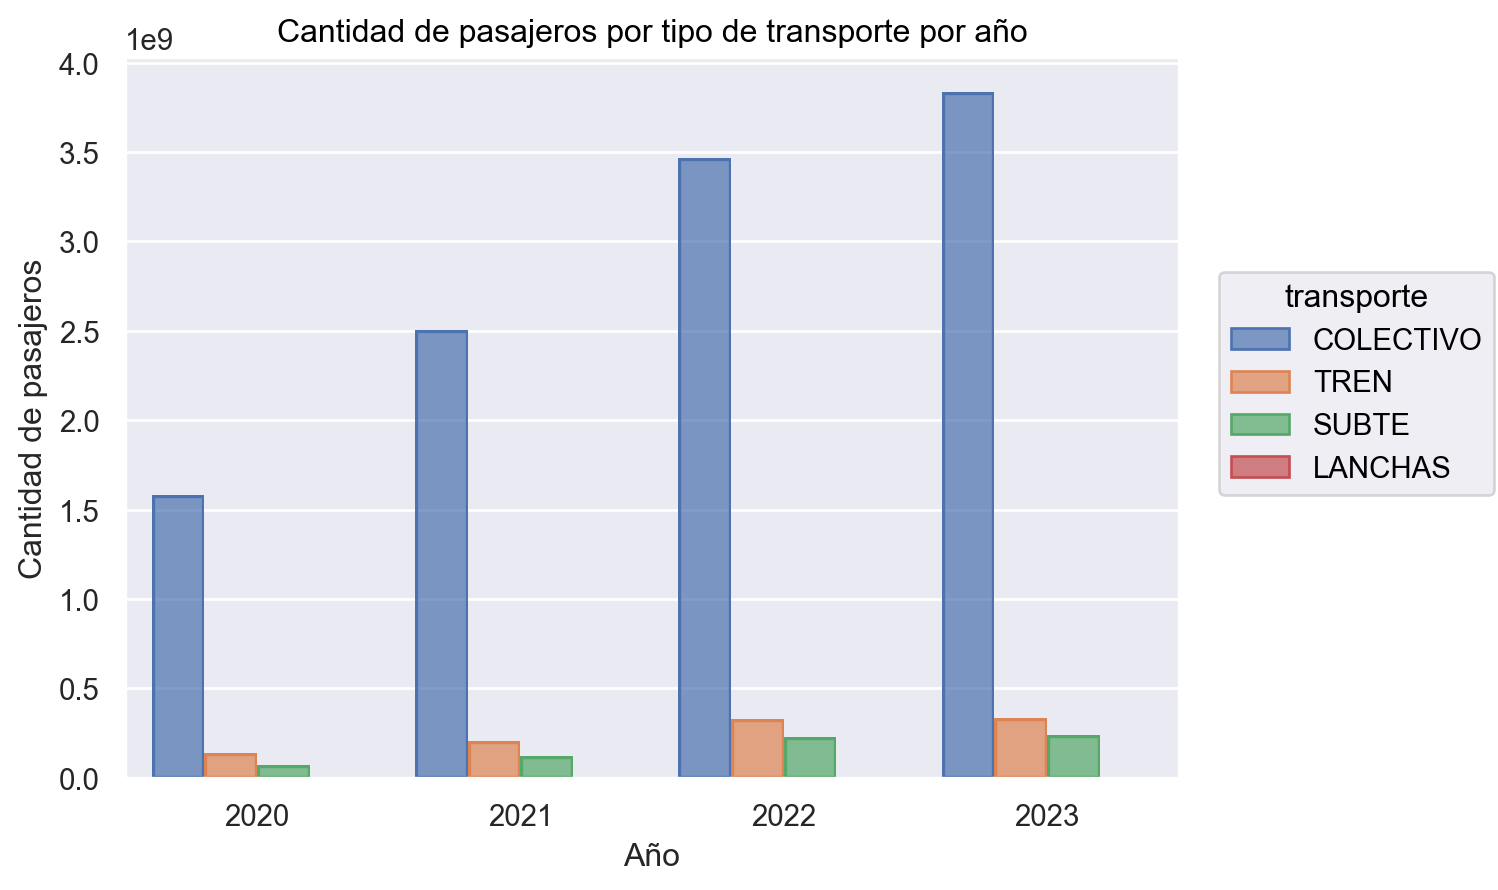

<Figure size 1200x600 with 0 Axes>

In [33]:
df_concatenado['DIA_TRANSPORTE'] = pd.to_datetime(df_concatenado['DIA_TRANSPORTE'], format='%Y-%m-%d')
df_concatenado['AÑO'] = df_concatenado['DIA_TRANSPORTE'].dt.year
plt.figure(figsize=(12, 6))
so.Plot(data=df_concatenado, x="AÑO", y="CANTIDAD", color = "TIPO_TRANSPORTE").add(so.Bar(), so.Agg("sum"), so.Dodge()).scale(x=so.Nominal()).label(title="Cantidad de pasajeros por tipo de transporte por año", x="Año", y="Cantidad de pasajeros", color= "transporte" )

En este grafico podemos ver que el uso del transporte publico incrementa año tras año, si bien hay que tener en cuenta que en el año 2020 el uso de este bajó abruptamente debido a la pandemia de COVID-19, la cual se extendio hacia inicios del 2021 en muchos sectores. Las oficinas al igual que los establecimientos educativos adoptaron modos de trabajo virtual, lo que consecuentemente hizo que la poblacion tenga que salir menos de sus casas y por lo tanto tomar menos colectivos, subtes, trenes y lanchas. A partir del 2022 se ve un fuerte incremento del uso de dichos transportes con la pandemia ya dejada de lado, es probable que con los incrementos de los costos de mantener un vehiculo propio en los proximos años sigan subiendo los numeros de pasajeros.

##### Gráfico 6

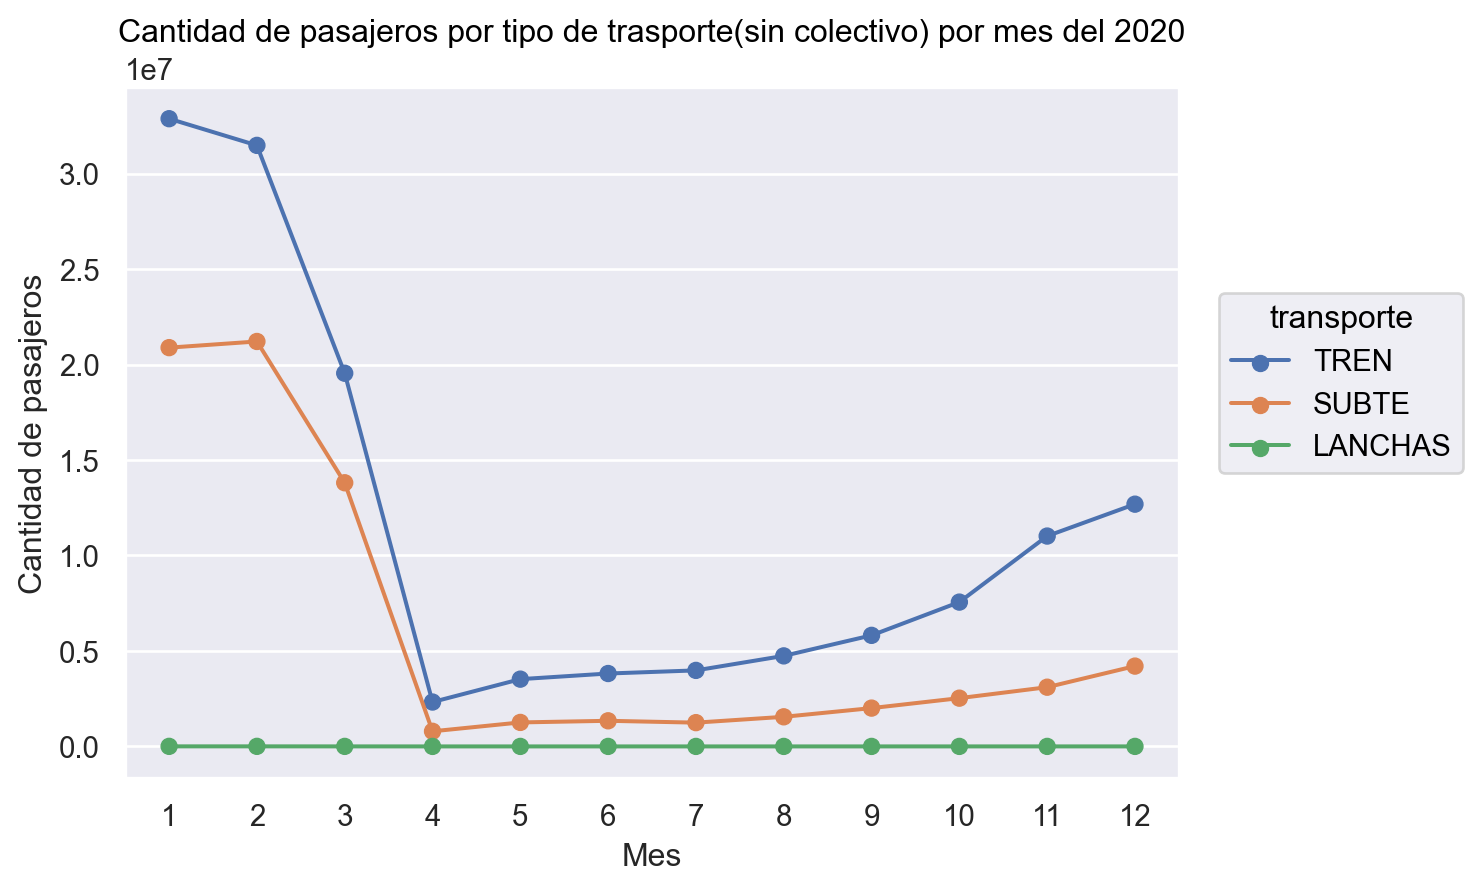

<Figure size 1200x600 with 0 Axes>

In [34]:
plt.figure(figsize=(12, 6))
dataset_sube20['DIA_TRANSPORTE'] = pd.to_datetime(dataset_sube20['DIA_TRANSPORTE'], format='%Y-%m-%d')
dataset_sube20["MES"]= dataset_sube20["DIA_TRANSPORTE"].dt.month
so.Plot(data=dataset_sube20[dataset_sube20["TIPO_TRANSPORTE"] !="COLECTIVO"], x="MES", y="CANTIDAD", color = "TIPO_TRANSPORTE").add(so.Dot(), so.Agg("sum")).add(so.Line(), so.Agg("sum")).scale(x=so.Nominal()).label(title="Cantidad de pasajeros por tipo de trasporte(sin colectivo) por mes del 2020", x="Mes", y="Cantidad de pasajeros", color= "transporte" )

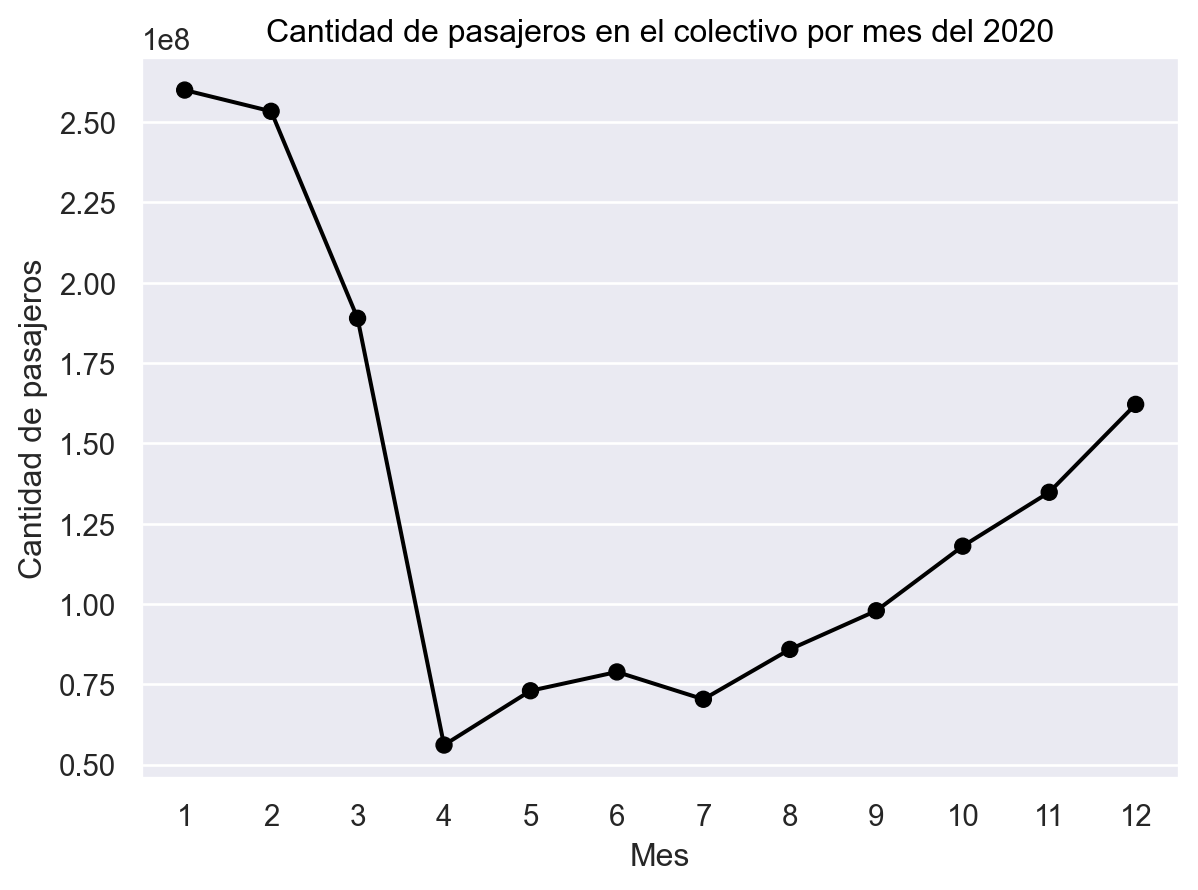

<Figure size 1200x600 with 0 Axes>

In [35]:
plt.figure(figsize=(12, 6))
so.Plot(data=dataset_sube20[dataset_sube20["TIPO_TRANSPORTE"] =="COLECTIVO"], x="MES", y="CANTIDAD").add(so.Dot(color="black"), so.Agg("sum")).add(so.Line(color="black"), so.Agg("sum")).scale(x=so.Nominal()).label(title="Cantidad de pasajeros en el colectivo por mes del 2020", x="Mes", y="Cantidad de pasajeros" )

Primero tomamos por separado los datos del colectivo con los de los demas transportes ya que tenian escalas distintas y no se podian apreciar bien todos los transportes juntos solo en un grafico. Ambos analizan el uso de los transportes mes a mes en el año 2020 atravezado por la pandemia del COVID-19. Este año fue un tanto particular ya que el dia 19 del mes de marzo el Presidente de la Nación Alberto Fernández decretó la cuarentena en todo el territorio nacional, lo cual se ve bien expresado en el grafico ya que a partir de marzo cae drasticamente el uso del transporte publico, llegando en abril(mes en el cual el aislamiento fue obligatorio en su totalidad) a su punto mas bajo. Poco a poco se fueron liberando ciertos sectores con el uso del distanciamiento social, pero muchos otros durante todo el año no volvieron a tener funcionamiento normal, esto explica la poca creciente en tanto al uso de tranasporte publico, el cual en ningun mes supera a enero y febrero, que usualmente son los meses en los que menos se utilizan ya que mucha gente esta de vacasiones.

##### Gráfico 7

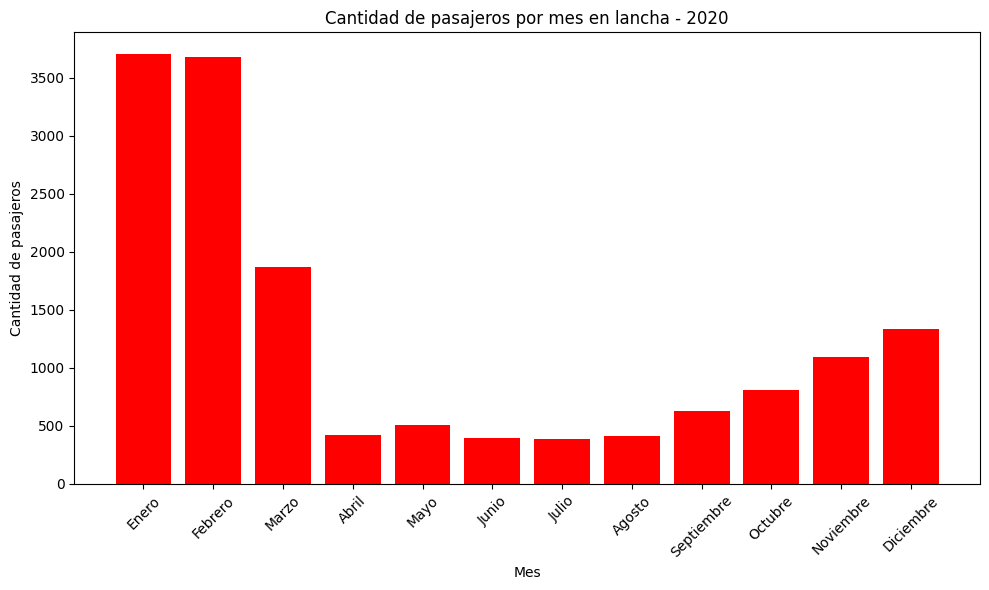

In [36]:
dataset_sube20['DIA_TRANSPORTE'] = pd.to_datetime(dataset_sube20['DIA_TRANSPORTE'])
dataset_sube20['MES'] = dataset_sube20['DIA_TRANSPORTE'].dt.month

lanchas_data_2020 = dataset_sube20[dataset_sube20['TIPO_TRANSPORTE'] == 'LANCHAS']

pasajeros_por_mes = lanchas_data_2020.groupby('MES')['CANTIDAD'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(pasajeros_por_mes['MES'], pasajeros_por_mes['CANTIDAD'], color='r')
plt.title('Cantidad de pasajeros por mes en lancha - 2020')
plt.xlabel('Mes')
plt.ylabel('Cantidad de pasajeros')
plt.xticks(pasajeros_por_mes['MES'], ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre'], rotation=45)

plt.tight_layout()
plt.show()

En este gráfico podemos observar mejor cómo afectó la pandemia en el uso de las lanchas. Más allá de que generalmente en los meses del verano (Enero, Febrero, Marzo) se utilizan las lanchas en mayor cantidad que en otros meses del año, ya que el clima es caluroso y la gente elige pasar tiempo en el rio, hay que tener en cuenta que en particular en el 2020, en el mes de Marzo inició la pandemia, por ende esto hace que la diferencia de la mediana de cantidad de pasajeros entre los meses del verano y los demás meses del año sea mayor que lo normal. Luego se puede observar un aumento gradual en la segunda mitad del año, esto podría indicar una recuperación en el uso de las lanchas a medida que las restricciones se reducian y las personas comenzaban a retomar sus actividades.

##### Gráfico 8

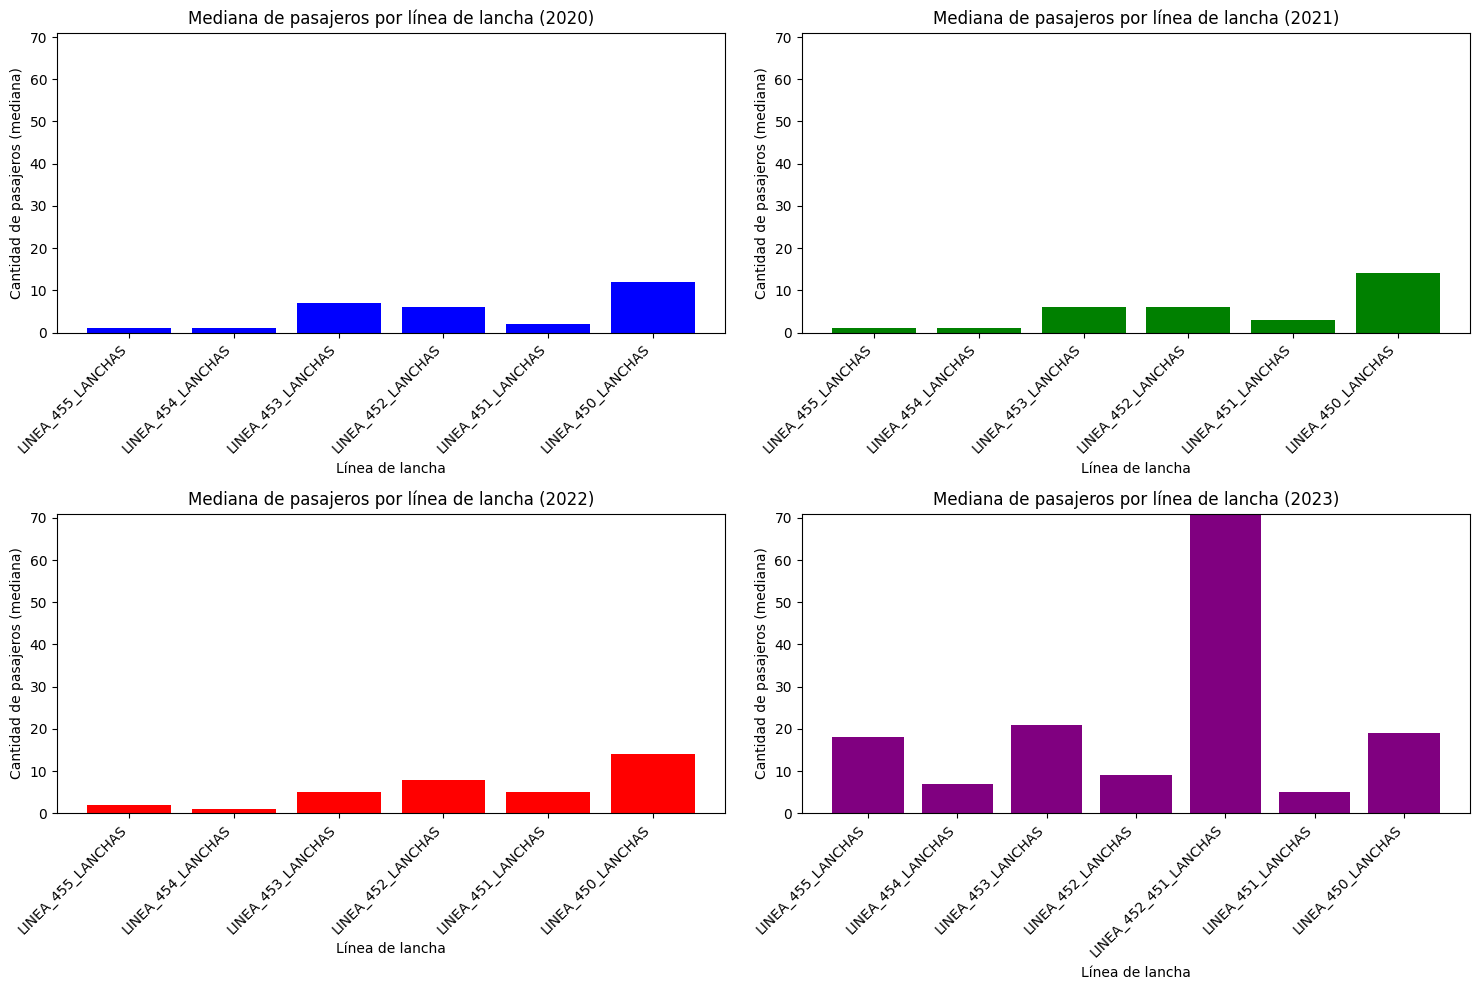

In [37]:
lanchas_data = df_concatenado[df_concatenado['TIPO_TRANSPORTE'] == 'LANCHAS']

def obtener_medianas_por_año(data, year):
    data_año = data[data['AÑO'] == year]
    medianas = data_año.groupby('LINEA')['CANTIDAD'].median().reset_index()
    return medianas.sort_values(by='LINEA', ascending=False)

lanchas_medianas20 = obtener_medianas_por_año(lanchas_data, 2020)
lanchas_medianas21 = obtener_medianas_por_año(lanchas_data, 2021)
lanchas_medianas22 = obtener_medianas_por_año(lanchas_data, 2022)
lanchas_medianas23 = obtener_medianas_por_año(lanchas_data, 2023)

max_medianas = max(lanchas_medianas20['CANTIDAD'].max(), lanchas_medianas21['CANTIDAD'].max(),
                   lanchas_medianas22['CANTIDAD'].max(), lanchas_medianas23['CANTIDAD'].max())

fig, axes = plt.subplots(2, 2, figsize=(15, 10))


axes[0, 0].bar(lanchas_medianas20['LINEA'], lanchas_medianas20['CANTIDAD'], color='b')
axes[0, 0].set_title('Mediana de pasajeros por línea de lancha (2020)')
axes[0, 0].set_xlabel('Línea de lancha')
axes[0, 0].set_ylabel('Cantidad de pasajeros (mediana)')
axes[0, 0].set_ylim(0, max_medianas) 
plt.setp(axes[0, 0].get_xticklabels(), rotation=45, ha='right')

axes[0, 1].bar(lanchas_medianas21['LINEA'], lanchas_medianas21['CANTIDAD'], color='g')
axes[0, 1].set_title('Mediana de pasajeros por línea de lancha (2021)')
axes[0, 1].set_xlabel('Línea de lancha')
axes[0, 1].set_ylabel('Cantidad de pasajeros (mediana)')
axes[0, 1].set_ylim(0, max_medianas) 
plt.setp(axes[0, 1].get_xticklabels(), rotation=45, ha='right')

axes[1, 0].bar(lanchas_medianas22['LINEA'], lanchas_medianas22['CANTIDAD'], color='r')
axes[1, 0].set_title('Mediana de pasajeros por línea de lancha (2022)')
axes[1, 0].set_xlabel('Línea de lancha')
axes[1, 0].set_ylabel('Cantidad de pasajeros (mediana)')
axes[1, 0].set_ylim(0, max_medianas) 
plt.setp(axes[1, 0].get_xticklabels(), rotation=45, ha='right')

axes[1, 1].bar(lanchas_medianas23['LINEA'], lanchas_medianas23['CANTIDAD'], color='purple')
axes[1, 1].set_title('Mediana de pasajeros por línea de lancha (2023)')
axes[1, 1].set_xlabel('Línea de lancha')
axes[1, 1].set_ylabel('Cantidad de pasajeros (mediana)')
axes[1, 1].set_ylim(0, max_medianas) 
plt.setp(axes[1, 1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

Estos gráficos no solo muestran cómo varió la mediana de pasajeros en las diferentes líneas de lancha durante los años 2020, 2021, 2022 y 2023, sino que también reflejan las posibles influencias externas que han afectado el uso del transporte acuático en los últimos años. En el gráfico del año 2020 se puede observar que la mediana es significativamente menor que la de los siguientes años ya que por la pandemia covid-19, la mayoría de personas no podían salir de sus casas y por ende se redujo el uso las lanchas (en el próximo gráfico analizaremos este interesante año más en detalle). En 2021, la mediana de pasajeros se estabilizó en comparación con 2020, las diferencias entre las líneas no son tan marcadas, lo que podría significar una distribución más uniforme del uso de las lanchas. Esto puede ser resultado de cambios en las políticas de transporte o en las rutas. En 2022, se nota un aumento en la mediana de pasajeros en varias líneas, esto nos muestra una posible recuperación en el uso de las lanchas. Este incremento podría estar relacionado con la reactivación económica y un regreso gradual a la normalidad post pandemia. En 2023, se puede ver un gran aumento en la mediana de la cantidad de pasajeros en comparación a los años anteriores, se podría decir que efectivamente se esta normalizando la movilidad y el uso de los transportes acuaticos despues de la pandemia.

##### Gráfico 9

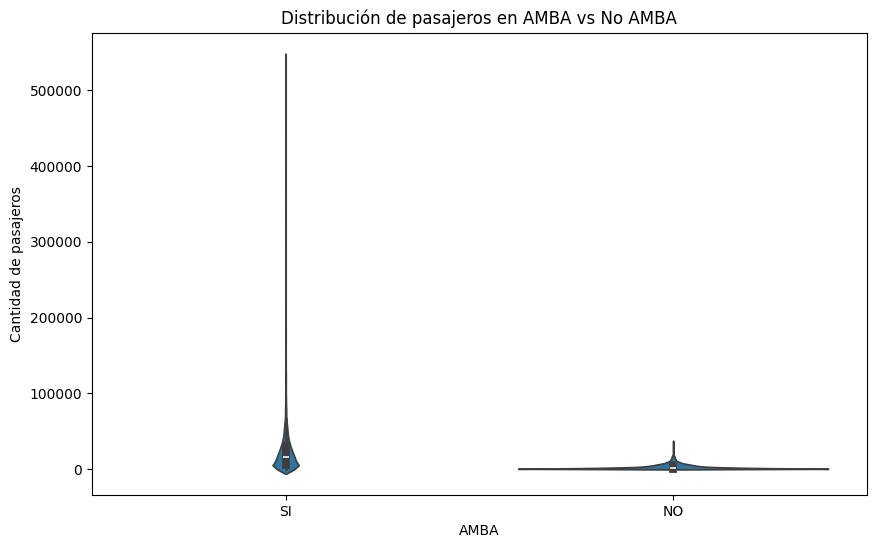

In [38]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=dataset_sube, x='AMBA', y='CANTIDAD')
plt.title('Distribución de pasajeros en AMBA vs No AMBA')
plt.xlabel('AMBA')
plt.ylabel('Cantidad de pasajeros')
plt.show()

Aca podemos ver que la media y mediana de pasajeros dentro y fuera de AMBA no es muy distinta, aunque los cuartiles en AMBA son mas extensos en valores. Ademas, como ya vimos en otros graficos, el espectro de valores que puede tomar la cantidad de pasajeros en AMBA es muy superior al resto de las provincias.

##### Gráfico 10

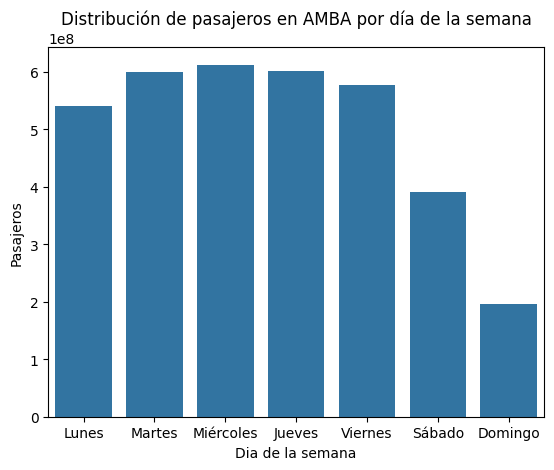

In [39]:
sns.barplot(data=datos_amba, x='fecha_dia', y='pasajeros', estimator='sum', order=dias, errorbar=None)
plt.title('Distribución de pasajeros en AMBA por día de la semana')
plt.ylabel('Pasajeros')
plt.xlabel('Dia de la semana')
plt.show()

Este gráfico nos muestra la cantidad total de pasajeros en AMBA en los días de la semana. En conclusión, como mencionamos anteriormente, podemos observar que el Miércoles es el día en el que viaja la mayor cantidad de gente, seguido vienen los Martes y Jueves, asumimos que esto se debe a que luego de la pandemia y con el comienzo del trabajo virtual o tambien llamado home office, las empresas continuaron con esta metodología de trabajo híbrido en la que los trabajadores eligen no ir presencial los Lunes y Viernes que son los dias pre y post fin de semana, esto se puede ver claramente reflejado en el uso del transporte público ya que estos días baja radicalmente el uso de la SUBE. Luego se puede ver que los sábados el uso del transporte publico se reduce pero la gran diferencia la marca el domingo, un dia en donde la gente prefiere quedarse en sus casas y no utilizar el transporte.

##### Gráfico 11

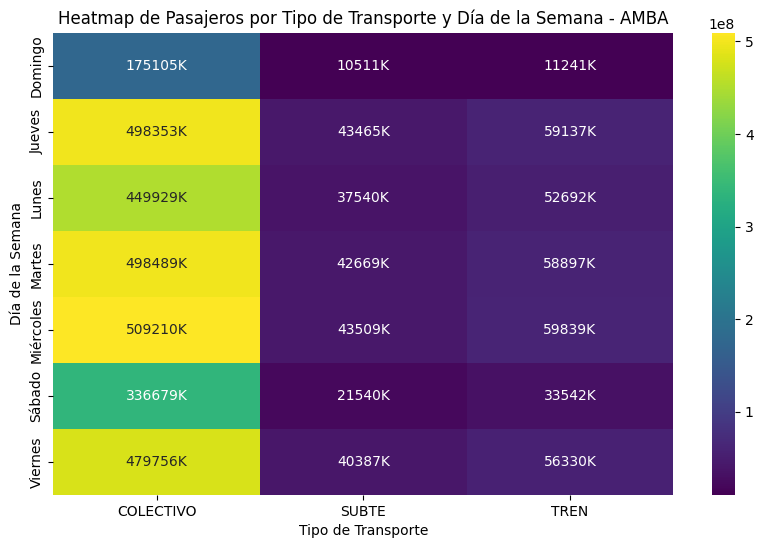

In [40]:
pivot_table = datos_amba.pivot_table(
    values='pasajeros', 
    index='fecha_dia', 
    columns='tipo_transporte', 
    aggfunc='sum', 
    fill_value=0,
)

def thousands(x, pos):
    return '%1.0fK' % (x * 1e-3)

plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(pivot_table, annot=True, fmt='d', cmap='viridis')
plt.title('Heatmap de Pasajeros por Tipo de Transporte y Día de la Semana - AMBA')
plt.xlabel('Tipo de Transporte')
plt.ylabel('Día de la Semana')

for t in heatmap.texts:
    t.set_text(thousands(float(t.get_text()), None))
    
plt.show()

En este gráfico podemos observar la cantidad total de pasajeros en miles (K), por tipo de transporte y día de la semana, usando los datos de AMBA. Podemos resaltar que en los días de semana, es decir, los días laborales, hay mayor cantidad de pasajeros en todos los transportes públicos en comparación a los fines de semana. El día de mayor uso de transporte en general es el Miércoles pero esto lo vamos a analizar en un gráfico siguiente. Tambien tenemos que destacar la diferencia de cantdad de pasajeros entre los tipos de transporte, por ejemplo se nota fuertemente que la mayor cantidad de personas utilizan los colectivos en vez de subte o tren, esto se debe a que los colectivos tienen más lineas que los otros dos medios y que llegan a más lugares, como sabemos los subtes solo existen en CABA y aunque los trenes si los podemos encontrar en varias provincias, no en todas y esto afecta a la cantidad de usos de estos medios.

##### Grafico 12

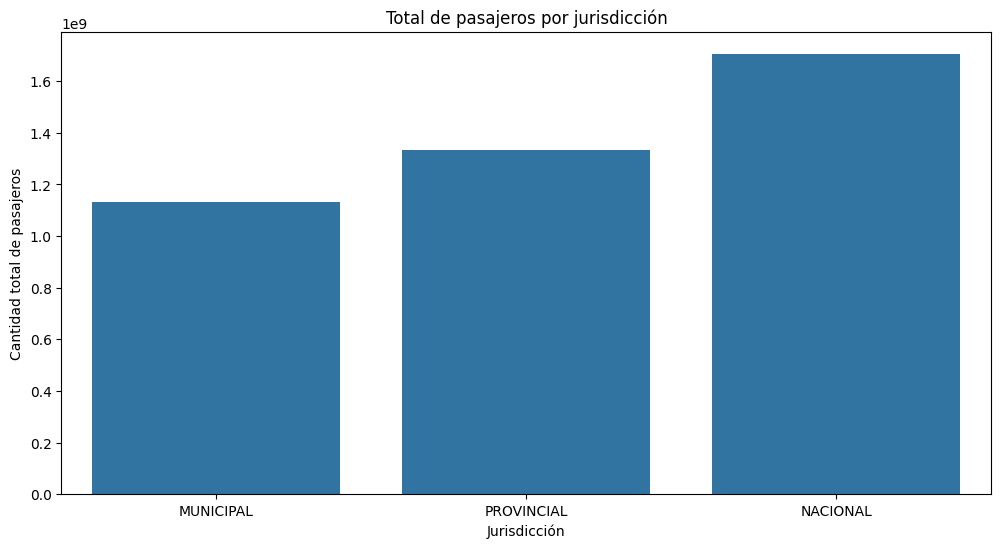

In [41]:
plt.figure(figsize=(12, 6))
sns.barplot(data=dataset_sube, x='JURISDICCION', y='CANTIDAD', estimator=sum, errorbar=None)
plt.title('Total de pasajeros por jurisdicción')
plt.xlabel('Jurisdicción')
plt.ylabel('Cantidad total de pasajeros')
plt.show()

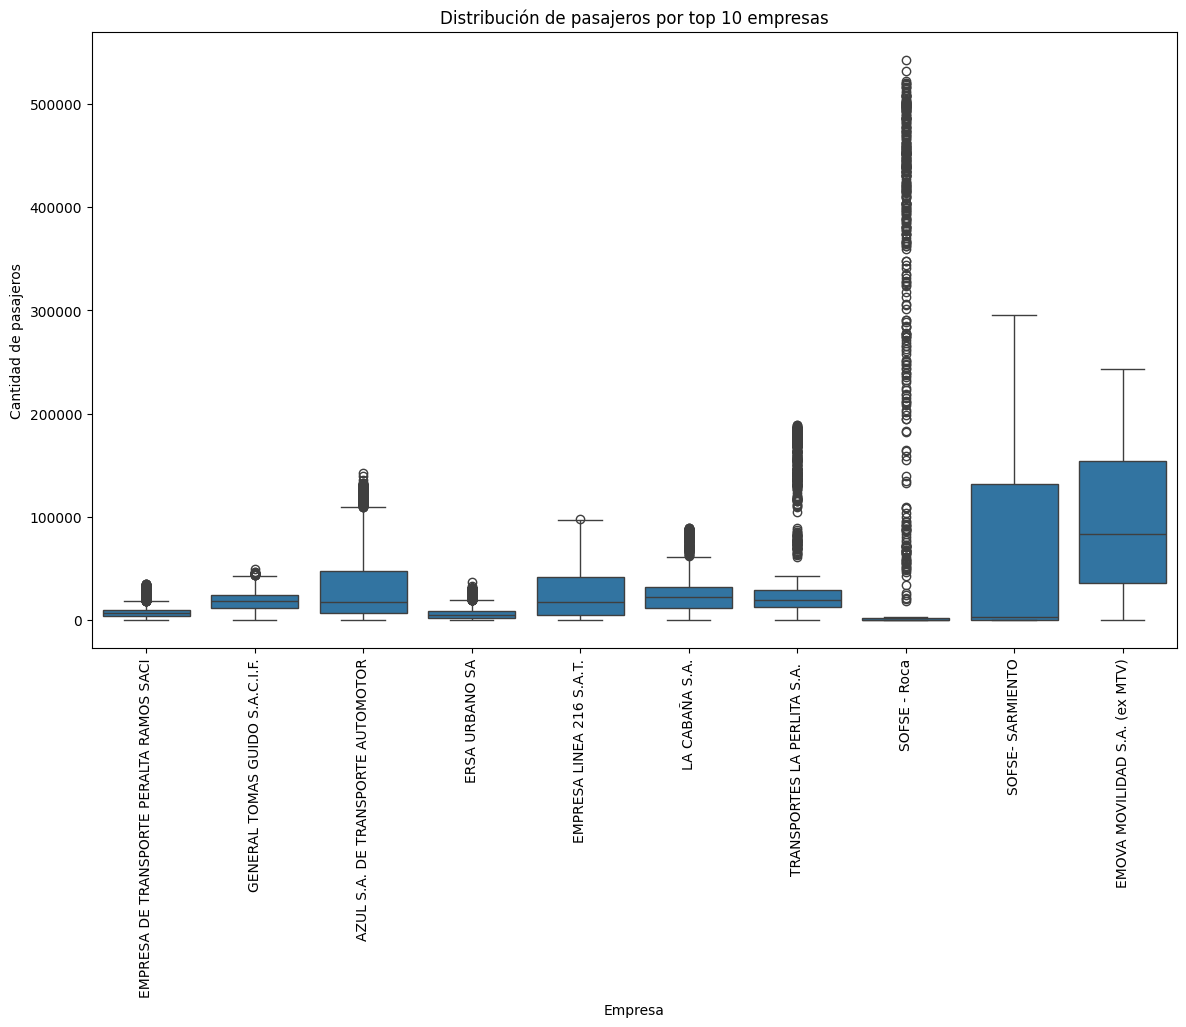

In [42]:
top_empresas = dataset_sube.groupby('NOMBRE_EMPRESA')['CANTIDAD'].sum().nlargest(10).index
df_top_empresas = dataset_sube[dataset_sube['NOMBRE_EMPRESA'].isin(top_empresas)]

plt.figure(figsize=(14, 8))
sns.boxplot(data=df_top_empresas, x='NOMBRE_EMPRESA', y='CANTIDAD')
plt.title('Distribución de pasajeros por top 10 empresas')
plt.xlabel('Empresa')
plt.ylabel('Cantidad de pasajeros')
plt.xticks(rotation=90)
plt.show()

In [43]:
#Reviso si hay datos que en la columna de provincia sean nan y que no sean subte ya que se que estos no tienen asignada ninguna provincia
dataset_sube[(dataset_sube["PROVINCIA"].isna()) & (dataset_sube["TIPO_TRANSPORTE"] != "SUBTE")].nunique()

DIA_TRANSPORTE     22
NOMBRE_EMPRESA      1
LINEA               1
AMBA                1
TIPO_TRANSPORTE     1
JURISDICCION        1
PROVINCIA           0
MUNICIPIO           0
CANTIDAD           22
DATO_PRELIMINAR     1
FECHA_DIA           7
FECHA_ORDINAL      22
FECHA_MES           1
dtype: int64

## Modelado

### Ejercicio 5

Creamos el dataset para los modelos y hacemos preprocesamiento

In [44]:
datos_ColectivoJN = dataset_sube_regresion[(dataset_sube_regresion['TIPO_TRANSPORTE']=='COLECTIVO') & (dataset_sube_regresion['PROVINCIA']=='JN') & (dataset_sube_regresion['AMBA']=='SI')]
cols = datos_ColectivoJN.LINEA.unique()

In [45]:
pasajeros_por_linea = pd.DataFrame()
for col in  cols:
    datos_linea = datos_ColectivoJN[datos_ColectivoJN.LINEA ==col][["DIA_TRANSPORTE", "CANTIDAD"]]
    datos_linea =datos_linea.set_index("DIA_TRANSPORTE").rename(columns ={"CANTIDAD" : col})
    pasajeros_por_linea = pd.concat([pasajeros_por_linea ,datos_linea], axis = 1)

In [46]:
pasajeros_por_linea = pasajeros_por_linea.dropna(axis=1)

In [47]:
pasajeros_por_linea.head()

,BS_ASLINEA_123,BSAS_LINEA_002,BSAS_LINEA_009,BSAS_LINEA_010,BSAS_LINEA_015,BSAS_LINEA_017,BSAS_LINEA_019,BSAS_LINEA_020,BSAS_LINEA_021,BSAS_LINEA_022,...,LINEA 4,LINEA 42,LINEA 44,LINEA 50,LINEA 6,LINEA 7,LINEA 76,LINEA 8,LINEA_099,LINEA_164_AMBA
DIA_TRANSPORTE,,,,,,,,,,,,,,,,,,,,,
2023-01-01,1681,5670,5644,5177,9109,7013,1604,2617,11235,2202,...,2942,4029,4649,4839,2449,2184,3797,5317,1882,3210
2023-01-02,9440,21759,23284,21176,45269,29962,13921,11934,55611,13823,...,15329,19072,20387,16221,10486,12774,17374,23250,10322,19362
2023-01-04,10540,24755,25405,23806,52873,33659,16172,13366,61721,16206,...,17836,21609,23595,18448,12193,13949,19860,26294,11981,21784
2023-01-05,10408,25772,26489,24688,53436,35182,16569,12929,62510,16863,...,18044,21993,23687,18481,12888,14668,21235,27216,11787,22972
2023-01-06,10530,26021,26458,24167,53163,35212,16459,12955,63528,16846,...,18122,22421,23731,19300,12703,14199,23472,27073,11567,23411


#### Regresion Lineal Univariada

Para este primer modelo, buscamos cuáles lineas de colectivo realizan recorrido similares a nuestra variable a ajusta, y de ellas nos quedamos con la Linea 075.

In [48]:
predictor_univ = pasajeros_por_linea[["BSAS_LINEA_075"]]

In [49]:
modelo_univ = linear_model.LinearRegression()    
modelo_univ.fit(predictor_univ, pasajeros_por_linea[['BSAS_LINEA_009']])

LinearRegression()

In [50]:
y_pred_univ = modelo_univ.predict(predictor_univ)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


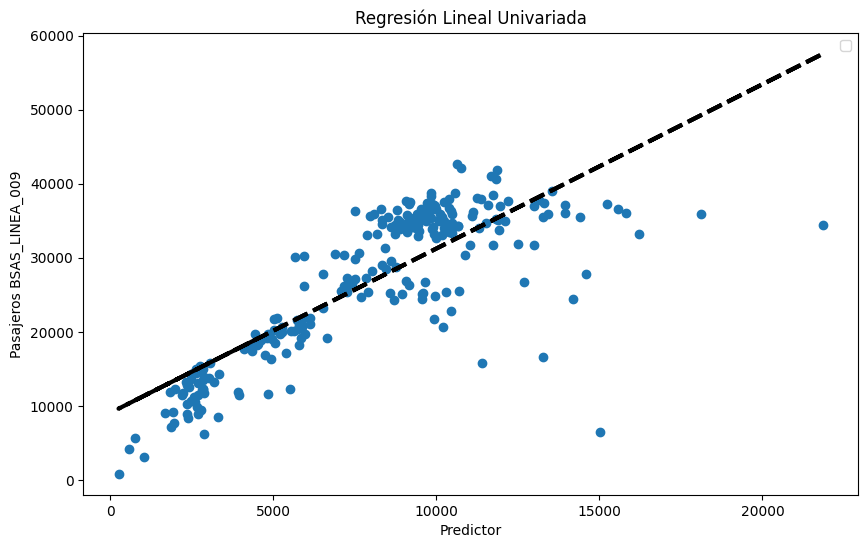

In [51]:
plt.figure(figsize=(10, 6))
plt.scatter(predictor_univ, pasajeros_por_linea[['BSAS_LINEA_009']])
plt.plot(predictor_univ, y_pred_univ,'k--', lw=3)
plt.xlabel('Predictor')
plt.ylabel('Pasajeros BSAS_LINEA_009')
plt.title('Regresión Lineal Univariada')
plt.legend()
plt.show()

In [52]:
print(f'Fórmula: Y = {modelo_univ.intercept_[0].round(1)} + {modelo_univ.coef_[0][0].round(1)}X')

Fórmula: Y = 9053.4 + 2.2X


In [53]:
mse = mean_squared_error(pasajeros_por_linea[['BSAS_LINEA_009']], y_pred_univ)
mae = mean_absolute_error(pasajeros_por_linea[['BSAS_LINEA_009']], y_pred_univ)
r2 = r2_score(pasajeros_por_linea[['BSAS_LINEA_009']], y_pred_univ)

print(f'Error Cuadrático Medio: {np.sqrt(mse)}')
print(f'Error Absoluto Medio: {mae}')
print(f'R2: {r2}')

Error Cuadrático Medio: 5900.913157626604
Error Absoluto Medio: 4350.357606480816
R2: 0.6564742168407034


#### Regresion Lineal Multivariada

En este caso, elejimos 5 columnas para entrenar el modelo en base a la varianza de los datos. Primero calculamos la varianza de la variable a predecir, Linea 009, y despues buscamos las 5 columnas que tengan varianza simialar a ésta.

In [54]:
varianzas = pasajeros_por_linea.var()

varianza_009 = varianzas['BSAS_LINEA_009']

diferencia_varianza = np.abs(varianzas - varianza_009)

columnas_mas_cercanas = diferencia_varianza.nsmallest(6).index  
columnas_mas_cercanas = columnas_mas_cercanas[columnas_mas_cercanas != 'BSAS_LINEA_009'] 
print(f'Lineas con las varianza mas cercana a la 009: {columnas_mas_cercanas.values}')


Lineas con las varianza mas cercana a la 009: ['BSAS_LINEA_067' 'BSAS_LINEA_169' 'BSAS_LINEA_100' 'BSAS_LINEA_078'
 'BSAS_LINEA_045']


In [55]:
modelo_multivariado = linear_model.LinearRegression() 

In [56]:
X_mv=pasajeros_por_linea[columnas_mas_cercanas]
y_mv=pasajeros_por_linea['BSAS_LINEA_009']
X_train_mv, X_test_mv, y_train_mv, y_test_mv = train_test_split(X_mv, y_mv, test_size=0.2, random_state=42)

In [57]:
modelo_multivariado.fit(X_train_mv, y_train_mv)

LinearRegression()

In [58]:
y_pred_mv = modelo_multivariado.predict(X_test_mv)

In [59]:
y_test_mv = y_test_mv.values.ravel()

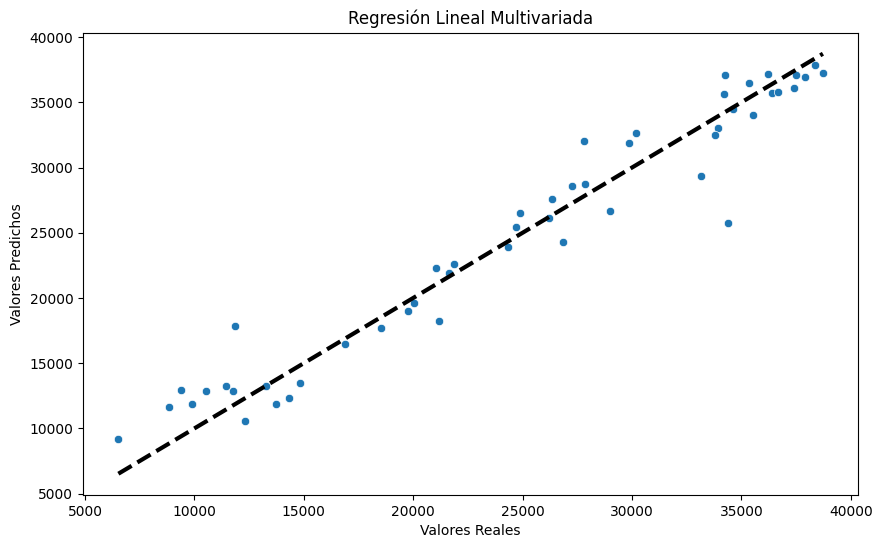

In [60]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_mv, y=y_pred_mv)
plt.plot([y_test_mv.min(), y_test_mv.max()], [y_test_mv.min(), y_test_mv.max()], 'k--', lw=3)
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Regresión Lineal Multivariada')
plt.show()

In [61]:
print(f'Fórmula: Y = {modelo_multivariado.intercept_.round(1)} + {modelo_multivariado.coef_[0].round(1)}*BSAS_LINEA_067 + {modelo_multivariado.coef_[1].round(1)}*BSAS_LINEA_169 + {modelo_multivariado.coef_[2].round(1)}*BSAS_LINEA_100 + {modelo_multivariado.coef_[3].round(1)}*BSAS_LINEA_078 + {modelo_multivariado.coef_[4].round(1)}*BSAS_LINEA_045')

Fórmula: Y = -551.2 + -0.0*BSAS_LINEA_067 + 0.4*BSAS_LINEA_169 + 0.8*BSAS_LINEA_100 + -0.2*BSAS_LINEA_078 + -0.1*BSAS_LINEA_045


In [62]:
mse = mean_squared_error(y_test_mv, y_pred_mv)
mae = mean_absolute_error(y_test_mv, y_pred_mv)
r2 = r2_score(y_test_mv, y_pred_mv)

print(f'Error Cuadrático Medio: {np.sqrt(mse)}')
print(f'Error Absoluto Medio: {mae}')
print(f'R2: {r2}')

Error Cuadrático Medio: 2284.738578930261
Error Absoluto Medio: 1708.9480010021348
R2: 0.9455414592956677


#### Regresion Ridge

Para este modelo vamos a calcular la correlación de todas las variables del dataset con nuestra variable a predecir, y vamos a tomar las 5 primeras para entrenar el modelo.

In [63]:
matriz_correlacion = pasajeros_por_linea.corr()
correlaciones = matriz_correlacion['BSAS_LINEA_009'].abs().sort_values(ascending=False)

top_5_lineas = correlaciones.index[1:6] 

print("Lineas con mejor correlación con Linea 009:", top_5_lineas)

Lineas con mejor correlación con Linea 009: Index(['LINEA 101', 'BSAS_LINEA_146', 'LINEA 7', 'BSAS_LINEA_024',
       'LINEA 107'],
      dtype='object')


In [64]:
dataset_modelo_ridge = pasajeros_por_linea[top_5_lineas.tolist() + ['BSAS_LINEA_009']]

In [65]:
dataset_modelo_ridge = dataset_modelo_ridge.rename(columns={'LINEA 101':'LINEA_101', 'LINEA 7':'LINEA_7', 'LINEA 107': 'LINEA_107'})

In [66]:
df_train, df_test = train_test_split(dataset_modelo_ridge, test_size=0.2, random_state=42)

formula = 'BSAS_LINEA_009 ~ (LINEA_101+BSAS_LINEA_146+LINEA_7+BSAS_LINEA_024+LINEA_107)'
y_ridge, X_ridge =  Formula(formula).get_model_matrix(df_train)

Proponemos alphas arbitrarios para el modelo

In [67]:
alphas = np.array([0.1, 0.3, 0.5, 1, 3, 7])

In [68]:
cv = KFold(n_splits=5, random_state=42, shuffle=True) 
for alpha in alphas:
    modeloRidge = linear_model.Ridge(alpha = alpha, fit_intercept = False)    
    rmse = np.zeros(cv.get_n_splits()) 

    ind = 0
    
    for train_index, val_index in cv.split(X_ridge):
        X_train, X_val, y_train, y_val = X_ridge.iloc[train_index], X_ridge.iloc[val_index], y_ridge.iloc[train_index], y_ridge.iloc[val_index]
        modeloRidge.fit(X_train, y_train)

        y_pred = modeloRidge.predict(X_val)
        rmse[ind] = np.sqrt(mean_squared_error(y_val, y_pred))
        ind = ind + 1

    print(f"Para alpha = {alpha:.5f} la raíz del Error Cuadratico Medio es: {rmse.mean():.5f}")

Para alpha = 0.10000 la raíz del Error Cuadratico Medio es: 1969.10853
Para alpha = 0.30000 la raíz del Error Cuadratico Medio es: 1968.99541
Para alpha = 0.50000 la raíz del Error Cuadratico Medio es: 1968.89038
Para alpha = 1.00000 la raíz del Error Cuadratico Medio es: 1968.65830
Para alpha = 3.00000 la raíz del Error Cuadratico Medio es: 1968.02640
Para alpha = 7.00000 la raíz del Error Cuadratico Medio es: 1967.42723


Hacemos una segunda corrida con valores cercanos al 7.

In [69]:
alphas = np.array([5, 7, 9, 11, 13, 15])

for alpha in alphas:
    modeloRidge = linear_model.Ridge(alpha = alpha, fit_intercept = False)    
    rmse = np.zeros(cv.get_n_splits()) 

    ind = 0

    for train_index, val_index in cv.split(X_ridge):
        X_train, X_val, y_train, y_val = X_ridge.iloc[train_index], X_ridge.iloc[val_index], y_ridge.iloc[train_index], y_ridge.iloc[val_index]
        modeloRidge.fit(X_train, y_train)

        y_pred = modeloRidge.predict(X_val)
        rmse[ind] = np.sqrt(mean_squared_error(y_val, y_pred))
        ind = ind + 1

    print(f"Para alpha = {alpha:.5f} la raiz del error cuadratico medio es: {rmse.mean():.5f}")


Para alpha = 5.00000 la raiz del error cuadratico medio es: 1967.66049
Para alpha = 7.00000 la raiz del error cuadratico medio es: 1967.42723
Para alpha = 9.00000 la raiz del error cuadratico medio es: 1967.26803
Para alpha = 11.00000 la raiz del error cuadratico medio es: 1967.15371
Para alpha = 13.00000 la raiz del error cuadratico medio es: 1967.06834
Para alpha = 15.00000 la raiz del error cuadratico medio es: 1967.00255


In [70]:
alpha_optimo = 15

modeloRidge = linear_model.Ridge(alpha = alpha_optimo, fit_intercept = False)    
modeloRidge.fit(X_ridge, y_ridge)

Ridge(alpha=15, fit_intercept=False)

In [71]:
y_test_ridge, X_test_ridge =  Formula(formula).get_model_matrix(df_test)
        
y_pred_ridge = modeloRidge.predict(X_test_ridge)

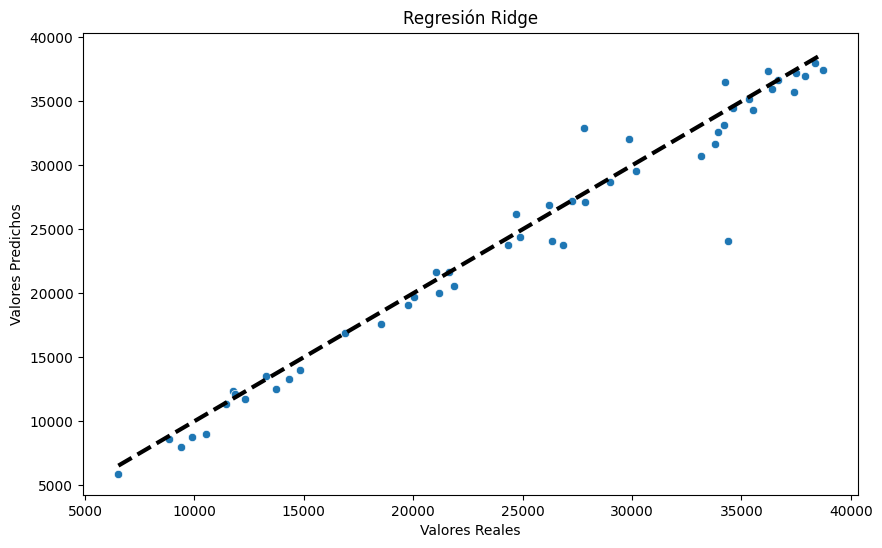

In [72]:
y_test_ridge_array = np.ravel(y_test_ridge)
y_pred_ridge_array = np.ravel(y_pred_ridge)

plt.figure(figsize=(10, 6))

sns.scatterplot(x=y_test_ridge_array, y=y_pred_ridge_array)
plt.plot([y_test_ridge_array.min(), y_test_ridge_array.max()], [y_test_ridge_array.min(), y_test_ridge_array.max()], 'k--', lw=3)
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Regresión Ridge')

plt.show()

In [73]:
mse = mean_squared_error(y_test_ridge, y_pred_ridge)
mae = mean_absolute_error(y_test_ridge, y_pred_ridge)
r2 = r2_score(y_test_ridge, y_pred_ridge)

print(f'Error Cuadrático Medio: {np.sqrt(mse)}')
print(f'Error Absoluto Medio: {mae}')
print(f'R2: {r2}')

Error Cuadrático Medio: 1989.9150508557807
Error Absoluto Medio: 1190.9900736718037
R2: 0.9586893485895117


In [74]:
coefs = modeloRidge.coef_[0].tolist()
coefs = coefs[1:]

In [75]:
formula_Ridge = f'Y = {modeloRidge.intercept_:.1f} '
for i in range(len(top_5_lineas)):
    formula_Ridge += f'+ ({coefs[i]:.2} * {top_5_lineas[i]}) '

print('Fórmula: ', formula_Ridge)

Fórmula:  Y = 0.0 + (0.36 * LINEA 101) + (0.034 * BSAS_LINEA_146) + (0.48 * LINEA 7) + (0.12 * BSAS_LINEA_024) + (0.034 * LINEA 107) 


#### Resultados modelos:

Siendo los resultados de las evaluaciones para los modelos los siguientes:
- Regresión univariada:
    - Error Cuadrático Medio: 5900.913157626604
    - Error Absoluto Medio: 4350.357606480816
    - R2: 0.6564742168407034


- Regresión multivariada:
    - Error Cuadrático Medio: 2284.738578930261
    - Error Absoluto Medio: 1708.9480010021348
    - R2: 0.9455414592956677


- Regresión Ridge:
    - Error Cuadrático Medio: 1989.9150508557807
    - Error Absoluto Medio: 1190.9900736718037
    - R2: 0.9586893485895117
    


Concluimos que la regresión Ridge es la que mejor ajusta a la línea BSAS_LINEA_009 para realizar predicciones.